In [1]:
import pyspark
import findspark
findspark.init() 

from pyspark.sql import SparkSession
from pyspark import SparkContext,SparkConf

from datetime import date
import json
import matplotlib.pyplot as plt
import pickle
import datetime

# Import SparkSession
conf = SparkConf().setAppName("lab2").setMaster("local")
sc = SparkContext(conf=conf)

#Creating a spark session
spark=SparkSession(sc)

#spark.stop()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/13 16:53:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
today = str(datetime.datetime.today()).split()[0]
today = str(datetime.datetime.today()).split()[0][0:7] #year and month
today

'2022-06'

# Read from Persistent landing


In [3]:
# Reading the parquet file from HDFS
read_pfile = spark.read.parquet('hdfs://10.4.41.85:27000/user/bdm/dataset/provider_'+today+'.parquet')
#read_pfile.printSchema()
#read_pfile.show(5)
#_out=read_pfile.rdd.map(lambda row: row.asDict())
#_out.sortBy('working_units_per_hour')

read_tfile = spark.read.parquet('hdfs://10.4.41.85:27000/user/bdm/dataset/tenant_'+today+'.parquet')
read_tfile.show(5)

+---+--------+-------------------+----+------------+------------------+-------------+
| ID|    name|           deadline|type|data_size_GB|RAM_requirement_GB|working_units|
+---+--------+-------------------+----+------------+------------------+-------------+
| T0|   Tyler|2022-06-29 17:00:00| CPU|         100|               128|          630|
| T1| Dainton|2022-06-26 08:00:00| CPU|          50|                32|         1065|
| T2|  Arthur|2022-06-23 15:00:00| CPU|          80|                 8|          950|
| T3|   Blake|2022-06-22 07:00:00| CPU|          95|                 8|          360|
| T4|Nicholas|2022-06-25 04:00:00| CPU|          80|                64|         1080|
+---+--------+-------------------+----+------------+------------------+-------------+
only showing top 5 rows



# Data formatters

In [4]:
read_pfile.createOrReplaceTempView("p_view")
p_file = spark.sql("SELECT * FROM p_view ").rdd
#p_file.map(lambda row: row.asDict()).sortBy('working_units_per_hour')
data1 = p_file.map(lambda line: (line['ID'],line['available_start_time'],line['available_end_time'],line['type'],line['disk_size'],line['CPU_RAM_GB'],line['GPU_RAM_GB'],line['working_units_per_hour'] ))
#print(p_file.map(lambda line: (line['ID'],line['available_start_time'],line['available_end_time'],line['type'],line['disk_size'],line['CPU_RAM_GB'],line['GPU_RAM_GB'],line['working_units_per_hour'] )).collect())
#_out = p_out.sortBy('working_units_per_hour', ascending=False)
#print(_out)
#type(abc)
#.take(2))
#data1 = sc.parallelize(a)
data1.collect()[0:2]

[('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50),
 ('R1',
  '2022-06-06 09:00:00',
  '2022-06-23 02:00:00',
  'GPU',
  100,
  1024,
  1024,
  45)]

In [5]:
read_tfile.createOrReplaceTempView("t_view")
t_file = spark.sql("SELECT * FROM t_view ").rdd
data2=t_file.map(lambda line: (line['ID'],line['deadline'],line['type'],line['data_size_GB'],line['RAM_requirement_GB'],line['working_units'] ))
#print(t_file.map(lambda line: (line['ID'],line['deadline'],line['type'],line['data_size_GB'],line['RAM_requirement_GB'],line['working_units'] )).collect())
#data2=sc.parallelize(b)
data2.collect()[0:2]

[('T0', '2022-06-29 17:00:00', 'CPU', 100, 128, 630),
 ('T1', '2022-06-26 08:00:00', 'CPU', 50, 32, 1065)]

# Save to HDFS (Formatted Zone)

In [6]:
with open(today+"_provider", "wb") as fp:   #Pickling
    pickle.dump(data1.collect(), fp)

with open(today+"_task", "wb") as fp:   #Pickling
    pickle.dump(data2.collect(), fp)


--------------------------

# Read from Formatted Zone, and Implementing Scheduling Algorithm (i.e. Explotation Zone)

## Spaek part

In [7]:
with open(today+"_provider", "rb") as fp:   # Unpickling
    data1_ = pickle.load(fp)
    
with open(today+"_task", "rb") as fp:   # Unpickling
    data2_ = pickle.load(fp)
    
data1 = sc.parallelize(data1_)
data2 = sc.parallelize(data2_)

In [8]:
cartesian_Rkey = data1.cartesian(data2)
print(len(cartesian_Rkey.collect()))
cartesian_Rkey.collect()[0:2]

2400000


[(('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50),
  ('T0', '2022-06-29 17:00:00', 'CPU', 100, 128, 630)),
 (('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50),
  ('T1', '2022-06-26 08:00:00', 'CPU', 50, 32, 1065))]

In [9]:
a = cartesian_Rkey.collect()
print(a[0])
print('------------')
print(a[0][0])
print('--')
print(a[0][1])

(('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50), ('T0', '2022-06-29 17:00:00', 'CPU', 100, 128, 630))
------------
('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50)
--
('T0', '2022-06-29 17:00:00', 'CPU', 100, 128, 630)


In [10]:
Rkey_rdd1 = cartesian_Rkey.filter(lambda t:( (t[0][3]==t[1][2])&(t[0][4]>t[1][3])&(t[0][5]>t[1][4]) ) if t[1][2]=='CPU'\
                                   else ( (t[0][3]==t[1][2])&(t[0][4]>t[1][3])&(t[0][6]>t[1][4]))  )
print(len(Rkey_rdd1.collect()))
Rkey_rdd1.collect()[0:2]

867330


[(('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50),
  ('T1', '2022-06-26 08:00:00', 'CPU', 50, 32, 1065)),
 (('R0', '2022-06-03 02:00:00', '2022-06-23 10:00:00', 'CPU', 190, 64, 32, 50),
  ('T2', '2022-06-23 15:00:00', 'CPU', 80, 8, 950))]

In [11]:
Rkey_rdd2 = Rkey_rdd1.sortBy(lambda x: x[1][1], ascending=True).sortBy(lambda x: x[0][7], ascending=False) #sortby tasks deadline
Rkey_rdd2.collect()[0:2]

[(('R24',
   '2022-06-08 06:00:00',
   '2022-06-26 08:00:00',
   'GPU',
   235,
   512,
   1024,
   50),
  ('T908', '2022-06-15 00:00:00', 'GPU', 50, 32, 605)),
 (('R72',
   '2022-06-03 05:00:00',
   '2022-06-27 19:00:00',
   'GPU',
   225,
   256,
   1024,
   50),
  ('T908', '2022-06-15 00:00:00', 'GPU', 50, 32, 605))]

In [12]:
Rkey_rdd3 = Rkey_rdd2.map(lambda t: (t[0][0],t[1][0]))
Rkey_rdd3.collect()[0:2]

[('R24', 'T908'), ('R72', 'T908')]

In [14]:
Rkey_rdd4 = Rkey_rdd3.reduceByKey(lambda a, b: a + '|' + b)
RT = Rkey_rdd4.collect()
RT[0:1]

[('R24',
  'T908|T3145|T3251|T3360|T3552|T5649|T5784|T897|T1034|T1746|T5137|T5534|T717|T2677|T3182|T3316|T4451|T5073|T5535|T5756|T5897|T5941|T1000|T2028|T3348|T3824|T4273|T4302|T4480|T59|T308|T366|T872|T923|T1631|T1803|T1968|T1975|T2736|T3277|T4528|T4859|T4895|T5865|T570|T612|T1400|T1812|T3592|T3667|T4214|T4465|T5445|T5854|T511|T1460|T2525|T3158|T3177|T3223|T3826|T3981|T4429|T5043|T402|T1724|T2485|T2629|T2637|T3797|T4890|T1188|T1887|T2670|T2962|T4312|T5938|T8|T61|T982|T2946|T4144|T4209|T4481|T608|T1132|T1798|T1837|T3730|T4419|T4878|T223|T1282|T1313|T1459|T1749|T3559|T3984|T5362|T147|T1070|T1907|T2696|T3242|T3931|T4787|T2448|T2843|T3021|T3921|T4171|T127|T309|T847|T1504|T2162|T2474|T4573|T4797|T5340|T486|T584|T639|T819|T2495|T3204|T3968|T5012|T5144|T4272|T1224|T2319|T2490|T2794|T3366|T3976|T4792|T5002|T5788|T5855|T1466|T1609|T118|T798|T1869|T3509|T4024|T4115|T4126|T4793|T5646|T385|T467|T1580|T1821|T2002|T2020|T2584|T3207|T4356|T5245|T2180|T3952|T4125|T4649|T5296|T5986|T607|T965|T1049|T11

## Spaek part

In [19]:
import pandas as pd
from calendar import monthrange
import datetime
################################################################
year = 2022
month = 6 #CHANGE
day_of_month = monthrange(year, month)[1]
start_time = datetime.datetime(2022, month, 1, 0, 0, 0) 
end_time = datetime.datetime(2022, month, day_of_month, 23, 0, 0)
row = []

In [20]:
t = start_time
while t <= end_time:
    t_str = t.strftime("%Y-%m-%d %H:%M:%S")
    row.append(t_str)
    t += datetime.timedelta(hours=1)

col = [i[0] for i in RT] 

len(row)
row[0:5]

['2022-06-01 00:00:00',
 '2022-06-01 01:00:00',
 '2022-06-01 02:00:00',
 '2022-06-01 03:00:00',
 '2022-06-01 04:00:00']

In [21]:
timetable = pd.DataFrame(columns=col, index=row, data='offline')
timetable[0:5]

R24      R72      R81      R96     R111     R120  \
2022-06-01 00:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 01:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 02:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 03:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 04:00:00  offline  offline  offline  offline  offline  offline   

                        R125     R129     R152     R153  ...     R351  \
2022-06-01 00:00:00  offline  offline  offline  offline  ...  offline   
2022-06-01 01:00:00  offline  offline  offline  offline  ...  offline   
2022-06-01 02:00:00  offline  offline  offline  offline  ...  offline   
2022-06-01 03:00:00  offline  offline  offline  offline  ...  offline   
2022-06-01 04:00:00  offline  offline  offline  offline  ...  offline   

                        R353     R354     R356      R66      R70     R148  \
2022-06-01 00:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 01:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 02:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 03:00:00  offline  offline  offline  offline  offline  offline   
2022-06-01 04:00:00  offline  offline  offline  offline  offline  offline   

                        R197     R293     R397  
2022-06-01 00:00:00  offline  offline  offline  
2022-06-01 01:00:00  offline  offline  offline  
2022-06-01 02:00:00  offline  offline  offline  
2022-06-01 03:00:00  offline  offline  offline  
2022-06-01 04:00:00  offline  offline  offline  

[5 rows x 400 columns]

In [22]:
resources = data1.collect()
resource_power_list = [[i[0],i[7]] for i in resources]

resource_power = {}
for i in resource_power_list:
    resource_power.setdefault(i[0],i[1])
    
resource_power

{'R0': 50,
 'R1': 45,
 'R2': 25,
 'R3': 20,
 'R4': 45,
 'R5': 45,
 'R6': 10,
 'R7': 35,
 'R8': 30,
 'R9': 30,
 'R10': 30,
 'R11': 50,
 'R12': 15,
 'R13': 45,
 'R14': 35,
 'R15': 45,
 'R16': 45,
 'R17': 25,
 'R18': 25,
 'R19': 15,
 'R20': 40,
 'R21': 15,
 'R22': 35,
 'R23': 20,
 'R24': 50,
 'R25': 45,
 'R26': 25,
 'R27': 50,
 'R28': 25,
 'R29': 50,
 'R30': 50,
 'R31': 45,
 'R32': 20,
 'R33': 15,
 'R34': 15,
 'R35': 20,
 'R36': 40,
 'R37': 50,
 'R38': 15,
 'R39': 45,
 'R40': 45,
 'R41': 45,
 'R42': 35,
 'R43': 20,
 'R44': 50,
 'R45': 20,
 'R46': 40,
 'R47': 45,
 'R48': 45,
 'R49': 35,
 'R50': 40,
 'R51': 45,
 'R52': 30,
 'R53': 45,
 'R54': 45,
 'R55': 50,
 'R56': 20,
 'R57': 30,
 'R58': 35,
 'R59': 10,
 'R60': 35,
 'R61': 25,
 'R62': 50,
 'R63': 35,
 'R64': 50,
 'R65': 20,
 'R66': 10,
 'R67': 35,
 'R68': 40,
 'R69': 45,
 'R70': 10,
 'R71': 45,
 'R72': 50,
 'R73': 20,
 'R74': 30,
 'R75': 15,
 'R76': 45,
 'R77': 35,
 'R78': 15,
 'R79': 35,
 'R80': 15,
 'R81': 50,
 'R82': 35,
 'R83': 35,
 '

In [25]:
tasks = data2.collect()
work_remain_list = [[i[0],i[5]] for i in tasks]

work_remain = {}
for i in work_remain_list:
    work_remain.setdefault(i[0],i[1])
    
work_remain

json.dump( work_remain, open( "work_remain"+str(month)+ "_ori.json", 'w' ) )

In [26]:
available_time = {}
for i in resources:
    available_time.setdefault(i[0],[i[1],i[2]])
available_time

{'R0': ['2022-06-03 02:00:00', '2022-06-23 10:00:00'],
 'R1': ['2022-06-06 09:00:00', '2022-06-23 02:00:00'],
 'R2': ['2022-06-05 21:00:00', '2022-06-13 13:00:00'],
 'R3': ['2022-06-05 08:00:00', '2022-06-18 12:00:00'],
 'R4': ['2022-06-06 15:00:00', '2022-06-18 23:00:00'],
 'R5': ['2022-06-08 02:00:00', '2022-06-14 21:00:00'],
 'R6': ['2022-06-07 13:00:00', '2022-06-11 19:00:00'],
 'R7': ['2022-06-05 22:00:00', '2022-06-20 12:00:00'],
 'R8': ['2022-06-05 04:00:00', '2022-06-29 11:00:00'],
 'R9': ['2022-06-01 19:00:00', '2022-06-13 22:00:00'],
 'R10': ['2022-06-07 08:00:00', '2022-06-10 15:00:00'],
 'R11': ['2022-06-01 12:00:00', '2022-06-24 18:00:00'],
 'R12': ['2022-06-05 16:00:00', '2022-06-11 10:00:00'],
 'R13': ['2022-06-04 11:00:00', '2022-06-25 11:00:00'],
 'R14': ['2022-06-04 19:00:00', '2022-06-13 10:00:00'],
 'R15': ['2022-06-05 16:00:00', '2022-06-10 10:00:00'],
 'R16': ['2022-06-02 17:00:00', '2022-06-29 11:00:00'],
 'R17': ['2022-06-08 06:00:00', '2022-06-16 17:00:00'],
 '

In [27]:
for i in timetable: #for every column, i is column's name
    #print(timetable[i]) #whole column
    mask = ((timetable[i].index > available_time[i][0]) & (timetable[i].index < available_time[i][1]))
    timetable[i].mask(mask, 'working', inplace=True)

timetable.to_csv('available_timetable-'+str(month)+'.csv') #CHANGE

In [28]:
RT_list = {}
for i in RT:
    i[1]
    RT_list.setdefault(i[0], i[1].split("|"))
    
RT_list

{'R24': ['T908',
  'T3145',
  'T3251',
  'T3360',
  'T3552',
  'T5649',
  'T5784',
  'T897',
  'T1034',
  'T1746',
  'T5137',
  'T5534',
  'T717',
  'T2677',
  'T3182',
  'T3316',
  'T4451',
  'T5073',
  'T5535',
  'T5756',
  'T5897',
  'T5941',
  'T1000',
  'T2028',
  'T3348',
  'T3824',
  'T4273',
  'T4302',
  'T4480',
  'T59',
  'T308',
  'T366',
  'T872',
  'T923',
  'T1631',
  'T1803',
  'T1968',
  'T1975',
  'T2736',
  'T3277',
  'T4528',
  'T4859',
  'T4895',
  'T5865',
  'T570',
  'T612',
  'T1400',
  'T1812',
  'T3592',
  'T3667',
  'T4214',
  'T4465',
  'T5445',
  'T5854',
  'T511',
  'T1460',
  'T2525',
  'T3158',
  'T3177',
  'T3223',
  'T3826',
  'T3981',
  'T4429',
  'T5043',
  'T402',
  'T1724',
  'T2485',
  'T2629',
  'T2637',
  'T3797',
  'T4890',
  'T1188',
  'T1887',
  'T2670',
  'T2962',
  'T4312',
  'T5938',
  'T8',
  'T61',
  'T982',
  'T2946',
  'T4144',
  'T4209',
  'T4481',
  'T608',
  'T1132',
  'T1798',
  'T1837',
  'T3730',
  'T4419',
  'T4878',
  'T223',
  

In [29]:
#Allocate the works
for i in timetable:  #every resource
    for j in range(len(timetable[i])): #every one hour
        if timetable[i][j] == 'working': 
            if len(RT_list[i]) == 0: #nothing in the task waiting list
                print(i+' have nothing to do')
                break
            else: #something in the waiting list
                run_task = RT_list[i][0] #choose the first one, the most urgent one (because it's sorted)
                if work_remain[run_task] > 0: #the task haven't finished
                    timetable[i][j] = run_task #assign the task for that resource in that hour
                    work_remain[run_task] -= resource_power[i] #task remain after running one hour
                    if work_remain[run_task] <= 0: #that task is done
                        print(run_task+' Done')
                        for k in RT_list:  #remove all that finished task from the waiting list of ALL resources
                            if run_task in RT_list[k]:
                                RT_list[k].remove(run_task)
                else:
                    print('error')
                            
timetable.to_csv('scheduling-'+str(month)+'.csv') 

T908 Done
T3145 Done
T3251 Done
T3360 Done
T3552 Done
T5649 Done
T5784 Done
T897 Done
T1034 Done
T1746 Done
T5137 Done
T5534 Done
T717 Done
T2677 Done
T3182 Done
T3316 Done
T4451 Done
T5073 Done
T5535 Done
T5756 Done
T5897 Done
T5941 Done
T1000 Done
T2028 Done
T3348 Done
T3824 Done
T4273 Done
T4302 Done
T4480 Done
T59 Done
T308 Done
T366 Done
T872 Done
T923 Done
T1631 Done
T1803 Done
T1968 Done
T1975 Done
T2736 Done
T3277 Done
T4528 Done
T4859 Done
T4895 Done
T5865 Done
T570 Done
T612 Done
T1400 Done
T1812 Done
T3592 Done
T3667 Done
T4214 Done
T4465 Done
T5445 Done
T5854 Done
T511 Done
T1460 Done
T2525 Done
T3158 Done
T3177 Done
T3223 Done
T3826 Done
T3981 Done
T4429 Done
T5043 Done
T402 Done
T1724 Done
T2485 Done
T2629 Done
T2637 Done
T3797 Done
T4890 Done
T1188 Done
T1887 Done
T2670 Done
T2962 Done
T4312 Done
T5938 Done
T8 Done
T61 Done
T982 Done
T2946 Done
T4144 Done
T4209 Done
T4481 Done
T1132 Done
T1837 Done
T4419 Done
T4878 Done
T223 Done
T1313 Done
T1749 Done
T3559 Done
T3984 Do

T4552 Done
T5047 Done
T5299 Done
T3372 Done
T4976 Done
T1008 Done
T1382 Done
T3412 Done
T4609 Done
T5713 Done
T5862 Done
T1106 Done
T1392 Done
T1462 Done
T1586 Done
T4693 Done
T4839 Done
T1155 Done
T1550 Done
T2294 Done
T3361 Done
T3724 Done
T5945 Done
T2732 Done
T2773 Done
T2829 Done
T3337 Done
T5772 Done
T1951 Done
T2346 Done
T3112 Done
T3000 Done
T2531 Done
T4980 Done
T3191 Done
T383 Done
T1836 Done
T2718 Done
T3193 Done
T3248 Done
T4543 Done
T4694 Done
T4934 Done
T5121 Done
T5424 Done
T5585 Done
T1175 Done
T1309 Done
T3192 Done
T520 Done
T696 Done
T767 Done
T2430 Done
T3229 Done
T3829 Done
T4304 Done
T4789 Done
T5269 Done
T293 Done
T531 Done
T2523 Done
T3363 Done
T4593 Done
T4971 Done
T5036 Done
T1661 Done
T2954 Done
T3429 Done
T5753 Done
T1417 Done
T2372 Done
T2841 Done
T4002 Done
T4337 Done
T2824 Done
T5539 Done
T183 Done
T734 Done
T1052 Done
T3886 Done
T2719 Done
T1363 Done
T1697 Done
T1948 Done
T2217 Done
T3114 Done
T4576 Done
T985 Done
T4270 Done
T5166 Done
T2047 Done
T2373 Do

T88 Done
T3010 Done
T3917 Done
T138 Done
T2298 Done
T4834 Done
T3253 Done
T3301 Done
T510 Done
T5243 Done
T2725 Done
T2926 Done
T3798 Done
T1419 Done
T1435 Done
T3330 Done
T3843 Done
T3856 Done
T3871 Done
T1044 Done
T2424 Done
T3494 Done
T56 Done
T1999 Done
T2118 Done
T3791 Done
T5053 Done
T32 Done
T2334 Done
T4688 Done
T5490 Done
T5656 Done
T1596 Done
T3079 Done
T4372 Done
T5886 Done
T1786 Done
T5655 Done
T18 Done
T318 Done
T3692 Done
T887 Done
T1344 Done
T1558 Done
T3636 Done
T2242 Done
T3857 Done
T796 Done
T2229 Done
T2767 Done
T876 Done
T3986 Done
T5789 Done
T1390 Done
T4692 Done
T3202 Done
T3699 Done
T3763 Done
T4351 Done
T5658 Done
T150 Done
T1064 Done
T2939 Done
T3978 Done
T4154 Done
T4169 Done
T5140 Done
T5150 Done
T5215 Done
T1888 Done
T3390 Done
T3604 Done
T4744 Done
T4876 Done
T5706 Done
T3307 Done
T3557 Done
T5728 Done
T2877 Done
T3459 Done
T3957 Done
T5158 Done
T5359 Done
T2455 Done
T1871 Done
T2137 Done
T3161 Done
T4195 Done
T4382 Done
T5858 Done
T545 Done
T907 Done
T1483

T2698 Done
T3895 Done
T4432 Done
T4512 Done
T3687 Done
T3930 Done
T4608 Done
T2848 Done
T5590 Done
T1103 Done
T2556 Done
T1025 Done
T1360 Done
T1723 Done
T2349 Done
T3477 Done
T4853 Done
T5705 Done
T962 Done
T3220 Done
T4850 Done
T1028 Done
T4697 Done
T489 Done
T1101 Done
T1130 Done
T3299 Done
T3783 Done
T4207 Done
T4479 Done
T5277 Done
T5403 Done
T91 Done
T468 Done
T1100 Done
T1753 Done
T4425 Done
T4595 Done
T4800 Done
T5203 Done
T1775 Done
T2375 Done
T3144 Done
T5810 Done
T1853 Done
T3841 Done
T4416 Done
T5550 Done
T5773 Done
T199 Done
T627 Done
T3462 Done
T5482 Done
T5670 Done
T5873 Done
T1076 Done
T1583 Done
T3682 Done
T4613 Done
T4737 Done
T2891 Done
T3520 Done
T4631 Done
T2068 Done
T1844 Done
T4473 Done
T2943 Done
T4847 Done
T3245 Done
T3779 Done
T1599 Done
T229 Done
T2649 Done
T5032 Done
T910 Done
T1356 Done
T3126 Done
T4488 Done
T4719 Done
T5146 Done
T1549 Done
T1582 Done
T1404 Done
T2175 Done
T3117 Done
T4114 Done
T5481 Done
T288 Done
T707 Done
T1267 Done
T1514 Done
T2916 Done

T3654 Done
T4305 Done
T115 Done
T2369 Done
T3567 Done
T5832 Done
T485 Done
T1574 Done
T2599 Done
T4182 Done
T4472 Done
T113 Done
T2605 Done
T4029 Done
T4676 Done
T589 Done
T1085 Done
T1182 Done
T3649 Done
T4569 Done
T5876 Done
T1875 Done
T2887 Done
T3473 Done
T216 Done
T1562 Done
T2389 Done
T4492 Done
T1299 Done
T3971 Done
T4289 Done
T3396 Done
T4141 Done
T4308 Done
T5651 Done
T198 Done
T4256 Done
T5471 Done
T2996 Done
T5450 Done
T2754 Done
T966 Done
T3256 Done
T1012 Done
T4523 Done
T5557 Done
T552 Done
T662 Done
T744 Done
T926 Done
T2674 Done
T2412 Done
T2830 Done
T3569 Done
T3707 Done
T230 Done
T838 Done
T1910 Done
T2093 Done
T2990 Done
T1695 Done
T748 Done
T217 Done
T5368 Done
T4094 Done
T1797 Done
T3080 Done
T5659 Done
T1818 Done
T2249 Done
T2128 Done
T3820 Done
T3365 Done
T3250 Done
T1338 Done
T3706 Done
T1793 Done
T3103 Done
T1863 Done
T2165 Done
T2770 Done
T3432 Done
T4314 Done
T5226 Done
T1366 Done
T1300 Done
T1378 Done
T1736 Done
T2109 Done
T2227 Done
T4048 Done
T2594 Done
T34

T2219 Done
T3586 Done
T4267 Done
T1107 Done
T1256 Done
T4152 Done
T364 Done
T682 Done
T3026 Done
T4298 Done
T4004 Done
T4244 Done
T5248 Done
T5452 Done
T1403 Done
T2208 Done
T3291 Done
T3915 Done
T4781 Done
T5417 Done
T1054 Done
T2170 Done
T2212 Done
T3490 Done
T4627 Done
T5161 Done
T626 Done
T3831 Done
T5205 Done
T5949 Done
T950 Done
T1216 Done
T5307 Done
T5357 Done
T31 Done
T3358 Done
T3460 Done
T3726 Done
T4088 Done
T4318 Done
T353 Done
T3108 Done
T3458 Done
T3684 Done
T4163 Done
T1893 Done
T297 Done
T5560 Done
T5815 Done
T2898 Done
T5606 Done
T3483 Done
T3924 Done
T809 Done
T1807 Done
T3341 Done
T4440 Done
T1564 Done
T1790 Done
T2914 Done
T2955 Done
T1332 Done
T2664 Done
T3104 Done
T846 Done
T4740 Done
T4168 Done
T4183 Done
T5022 Done
T597 Done
T2218 Done
T5878 Done
T5903 Done
T48 Done
T1608 Done
T4414 Done
T781 Done
T1075 Done
T2775 Done
T4770 Done
T980 Done
T5456 Done
T3377 Done
T1494 Done
T4192 Done
T4616 Done
T5027 Done
T2548 Done
T5909 Done
T2799 Done
T5112 Done
T189 Done
T422

T611 Done
T1969 Done
T4728 Done
T4875 Done
T5253 Done
T5347 Done
T5352 Done
T5609 Done
T2619 Done
T3068 Done
T594 Done
T5752 Done
T4160 Done
T5729 Done
T1077 Done
T1548 Done
T356 Done
T484 Done
T2459 Done
T4636 Done
T253 Done
T2222 Done
T3524 Done
T4050 Done
T3061 Done
T4011 Done
T5274 Done
T53 Done
T5290 Done
T5812 Done
T1679 Done
T3139 Done
T3266 Done
T3327 Done
T3359 Done
T5819 Done
T344 Done
T1201 Done
T2837 Done
T779 Done
T1142 Done
T1700 Done
T3875 Done
T4201 Done
T644 Done
T903 Done
T1017 Done
T3386 Done
T710 Done
T5748 Done
T5828 Done
T565 Done
T2097 Done
T793 Done
T3414 Done
T3553 Done
T3268 Done
T4386 Done
T5381 Done
T5641 Done
T3042 Done
T5513 Done
T1277 Done
T1716 Done
T3655 Done
T5361 Done
T801 Done
T807 Done
T496 Done
T999 Done
T4485 Done
T5480 Done
T23 Done
T2856 Done
T4766 Done
T4833 Done
T1120 Done
T1735 Done
T2901 Done
T4548 Done
T5817 Done
T901 Done
T1658 Done
T2404 Done
T2606 Done
T5244 Done
T5635 Done
T1621 Done
T2879 Done
T4892 Done
T1066 Done
T1147 Done
T1301 Don

T5306 Done
T5435 Done
T2036 Done
T5393 Done
T5836 Done
T5697 Done
T94 Done
T556 Done
T728 Done
T1501 Done
T1645 Done
T1822 Done
T2631 Done
T2747 Done
T4817 Done
T4841 Done
T157 Done
T2061 Done
T3119 Done
T5715 Done
T1682 Done
T4261 Done
T5957 Done
T5414 Done
T5652 Done
T2729 Done
T3916 Done
T4063 Done
T5334 Done
T789 Done
T2997 Done
T2303 Done
T3985 Done
T5101 Done
T5261 Done
T735 Done
T3907 Done
T522 Done
T4561 Done
T235 Done
T742 Done
T2852 Done
T4030 Done
T5225 Done
T5323 Done
T3137 Done
T97 Done
T4320 Done
T314 Done
T4520 Done
T1512 Done
T3278 Done
T517 Done
T4255 Done
T4883 Done
T2956 Done
T4307 Done
T2817 Done
T3433 Done
T3310 Done
T691 Done
T1829 Done
T2984 Done
T4776 Done
T283 Done
T912 Done
T3836 Done
T351 Done
T1733 Done
T2953 Done
T5838 Done
T266 Done
T2864 Done
T2961 Done
T3876 Done
T4231 Done
T2902 Done
T4437 Done
T3230 Done
T5598 Done
T3544 Done
T4254 Done
T875 Done
T211 Done
T3199 Done
T3260 Done
T5224 Done
T5976 Done
T301 Done
T1253 Done
T3683 Done
T3500 Done
T1031 Done

In [30]:
json.dump( work_remain, open( "work_remain"+str(month)+".json", 'w' ) )

In [31]:
work_remain

{'T0': 630,
 'T1': -10,
 'T2': -30,
 'T3': 0,
 'T4': 0,
 'T5': 0,
 'T6': -45,
 'T7': 435,
 'T8': -5,
 'T9': -15,
 'T10': -40,
 'T11': 355,
 'T12': 0,
 'T13': 0,
 'T14': -20,
 'T15': -40,
 'T16': -30,
 'T17': -15,
 'T18': -10,
 'T19': 0,
 'T20': -35,
 'T21': -15,
 'T22': 0,
 'T23': -10,
 'T24': -30,
 'T25': -10,
 'T26': 0,
 'T27': 0,
 'T28': -5,
 'T29': 420,
 'T30': -5,
 'T31': -15,
 'T32': -20,
 'T33': 420,
 'T34': -15,
 'T35': -25,
 'T36': -30,
 'T37': -5,
 'T38': 765,
 'T39': -35,
 'T40': -15,
 'T41': 630,
 'T42': -40,
 'T43': -35,
 'T44': -20,
 'T45': -5,
 'T46': 0,
 'T47': -5,
 'T48': -10,
 'T49': -10,
 'T50': -10,
 'T51': -15,
 'T52': 1090,
 'T53': -15,
 'T54': -45,
 'T55': -15,
 'T56': -35,
 'T57': -20,
 'T58': -45,
 'T59': -30,
 'T60': -20,
 'T61': -10,
 'T62': -35,
 'T63': -35,
 'T64': -25,
 'T65': -10,
 'T66': -10,
 'T67': 0,
 'T68': -25,
 'T69': -15,
 'T70': 430,
 'T71': -15,
 'T72': -5,
 'T73': -10,
 'T74': 0,
 'T75': -15,
 'T76': -5,
 'T77': -30,
 'T78': -40,
 'T79': -5,
 '

------------------------------------------------------------------------------------

# DASHBOARD

We will demonstrate 12 weeks of data (May-July)

In [22]:
provider5 = pd.read_csv('provider_2022-5.csv')
provider6 = pd.read_csv('provider_2022-6.csv')
provider7 = pd.read_csv('provider_2022-7.csv')

num5 = provider5.count(axis=0)[0]
num6 = provider6.count(axis=0)[0]
num7 = provider7.count(axis=0)[0]

In [23]:
timetable5 = pd.read_csv('scheduling-5.csv', index_col=0)
timetable6 = pd.read_csv('scheduling-6.csv', index_col=0)
timetable7 = pd.read_csv('scheduling-7.csv', index_col=0)
#separate week
wk = [timetable5[0:168], timetable5[168:336], timetable5[336:504], timetable5[504:672], \
      timetable6[0:168], timetable6[168:336], timetable6[336:504], timetable6[504:672], \
      timetable7[0:168], timetable7[168:336], timetable7[336:504], timetable7[504:672]]

In [24]:
GPUratio5 = provider5['type'].isin(['GPU']).sum(axis=0)/(provider5['type'].isin(['CPU']).sum(axis=0)+provider5['type'].isin(['GPU']).sum(axis=0))
GPUratio6 = provider6['type'].isin(['GPU']).sum(axis=0)/(provider6['type'].isin(['CPU']).sum(axis=0)+provider6['type'].isin(['GPU']).sum(axis=0))
GPUratio7 = provider7['type'].isin(['GPU']).sum(axis=0)/(provider7['type'].isin(['CPU']).sum(axis=0)+provider7['type'].isin(['GPU']).sum(axis=0))
GPUratio = [GPUratio5,GPUratio5,GPUratio5,GPUratio5,GPUratio6,GPUratio6,GPUratio6,GPUratio6,GPUratio7,GPUratio7,GPUratio7,GPUratio7]

In [35]:
utilized_work_unit = []
available_work_unit = []
j = 0
for i in wk:
    cnt1 = i.isin(['working']).sum(axis=0).sum()
    cnt2 = i.isin(['offline']).sum(axis=0).sum()
    if j<4:
        cnt3 = num5*168 - cnt2
        cnt4 = num5*168 - cnt1 - cnt2
    elif 4<=j<8:
        cnt3 = num6*168 - cnt2
        cnt4 = num6*168 - cnt1 - cnt2
    else:
        cnt3 = num7*168 - cnt2
        cnt4 = num7*168 - cnt1 - cnt2
    available_work_unit.append(cnt3)
    utilized_work_unit.append(cnt4)
    j += 1
    
utilization_rate = [x1/x2 for (x1, x2) in zip(utilized_work_unit, available_work_unit)]

#df1=pd.DataFrame(utilization_rate)
#df1.to_csv("//home/bdm/P2/utilization_rate.csv")
#df2=pd.DataFrame(available_work_unit)
#df2.to_csv("//home/bdm/P2/available_work_unit.csv")



In [33]:
available_GPU_unit = [int(round(x1*x2,0)) for (x1, x2) in zip(available_work_unit, GPUratio)]
available_CPU_unit = [int(round(x1*(1-x2),0)) for (x1, x2) in zip(available_work_unit, GPUratio)]
#df1 = pd.DataFrame(available_GPU_unit)
#df2 = pd.DataFrame(available_CPU_unit)
#df1.to_csv("//home/bdm/P2/available_GPU_unit.csv")
#df2.to_csv("//home/bdm/P2/available_CPU_unit.csv")


In [51]:
'''available_GPU_unit = [int(round(GPUratio5 * xx, 0)) for xx in available_work_unit]
available_CPU_unit = [int(round((1-GPUratio5) * xx, 0)) for xx in available_work_unit] '''

'available_GPU_unit = [int(round(GPUratio5 * xx, 0)) for xx in available_work_unit]\navailable_CPU_unit = [int(round((1-GPUratio5) * xx, 0)) for xx in available_work_unit] '

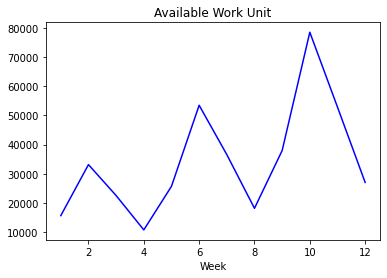

In [52]:
wk_num = [i+1 for i in range(12)]
plt.plot(wk_num, available_work_unit, color='b')
plt.xlabel('Week')
plt.title('Available Work Unit')
plt.show()

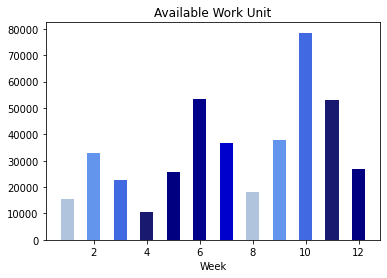

In [53]:
plt.bar(wk_num,
        available_work_unit, 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'])
plt.xlabel('Week')
plt.title('Available Work Unit')
plt.show()

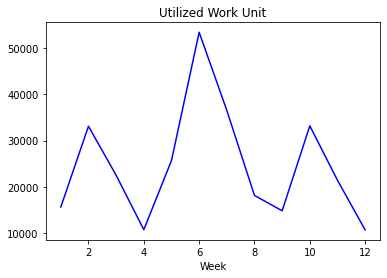

In [54]:
plt.plot(wk_num, utilized_work_unit, color='b')
plt.xlabel('Week')
plt.title('Utilized Work Unit')
plt.show()

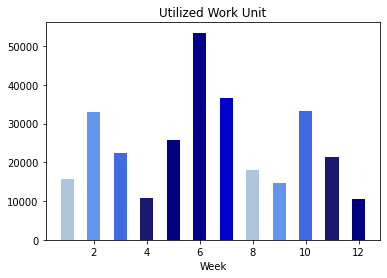

In [55]:
plt.bar(wk_num,
        utilized_work_unit, 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'])
plt.xlabel('Week')
plt.title('Utilized Work Unit')
plt.show()

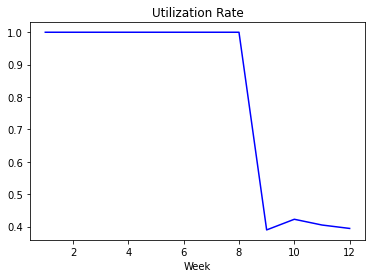

In [56]:
plt.plot(wk_num, utilization_rate, color='b')
plt.xlabel('Week')
plt.title('Utilization Rate')
plt.show()
#last month have too many  resources but too less tasks, resources start to idle

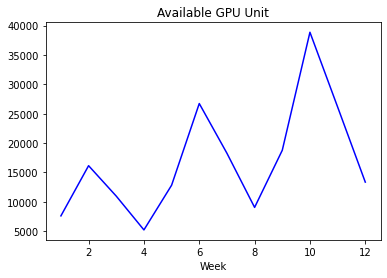

In [57]:
plt.plot(wk_num, available_GPU_unit, color='b')
plt.xlabel('Week')
plt.title('Available GPU Unit')
plt.show()

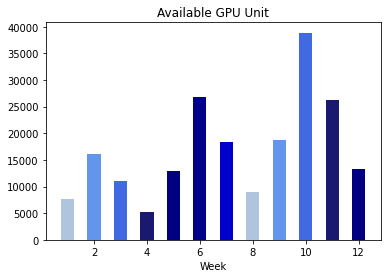

In [58]:
plt.bar(wk_num,
        available_GPU_unit, 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'])
plt.xlabel('Week')
plt.title('Available GPU Unit')
plt.show()

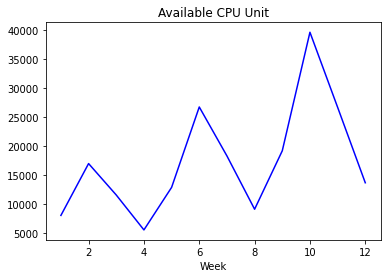

In [59]:
plt.plot(wk_num, available_CPU_unit, color='b')
plt.xlabel('Week')
plt.title('Available CPU Unit')
plt.show()

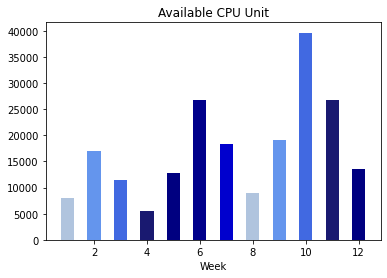

In [60]:
plt.bar(wk_num,
        available_CPU_unit, 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['lightsteelblue', 
               'cornflowerblue', 
               'royalblue', 
               'midnightblue', 
               'navy', 
               'darkblue', 
               'mediumblue'])
plt.xlabel('Week')
plt.title('Available CPU Unit')
plt.show()

In [37]:
work_remain5 = json.load( open( "work_remain5.json" ) )
work_remain6 = json.load( open( "work_remain6.json" ) )
work_remain7 = json.load( open( "work_remain7.json" ) )
work_remain5_ori = json.load( open( "work_remain5_ori.json" ) )
work_remain6_ori = json.load( open( "work_remain6_ori.json" ) )
work_remain7_ori = json.load( open( "work_remain7_ori.json" ) )
num_of_work = [len(work_remain5),len(work_remain6),len(work_remain7)]
num_of_work

#df1 = pd.DataFrame(num_of_work)
#df1.to_csv("//home/bdm/P2/num_of_work.csv")

In [38]:
work_done5 = 0
for key, value in work_remain5.items() :
    if value<=0:
        work_done5 += 1
work_done6 = 0
for key, value in work_remain6.items() :
    if value<=0:
        work_done6 += 1
work_done7 = 0
for key, value in work_remain7.items() :
    if value<=0:
        work_done7 += 1

num_of_work_done = [work_done5,work_done6,work_done7]
num_of_work_done

#df1 = pd.DataFrame(num_of_work_done)
#df1.to_csv("//home/bdm/P2/num_of_work_done.csv")

In [39]:
num_of_provider = [num5,num6,num7]
num_of_provider

# df1 = pd.DataFrame(num_of_provider)
# df1.to_csv("//home/bdm/P2/num_of_provider.csv")

In [64]:
work_done_rate = [x1/x2 for (x1, x2) in zip(num_of_work_done, num_of_work)]
work_done_rate

[0.5315, 0.9133333333333333, 1.0]

In [65]:
m_num = [5,6,7]

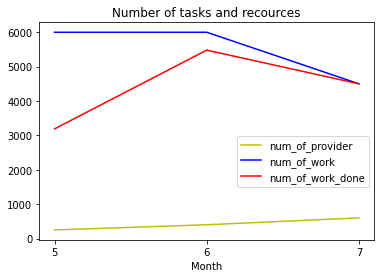

In [66]:
plt.plot(m_num, num_of_provider, color='y', label='num_of_provider')
plt.plot(m_num, num_of_work, 'b', label='num_of_work')
plt.plot(m_num, num_of_work_done, 'r', label='num_of_work_done')
plt.xlabel('Month')
plt.xticks(m_num) 
plt.title('Number of tasks and recources')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()


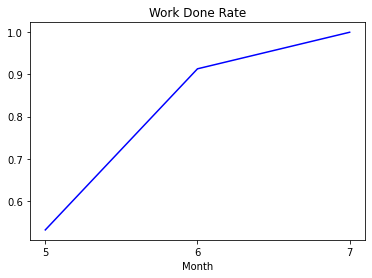

In [67]:
plt.plot(m_num, work_done_rate, color='b')
plt.xlabel('Month')
plt.xticks(m_num) 
plt.title('Work Done Rate')
plt.show()